# Hands-on Tutorial: Measuring Unintended Bias in Text Classification Models with Real Data


## Install library and data dependencies

---



In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import datetime
import os
import pandas as pd
import numpy as np
import pkg_resources
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scipy.stats as stats

from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.models import Model
from keras.models import load_model

%matplotlib inline

# autoreload makes it easier to interactively work on code in imported libraries
%load_ext autoreload
%autoreload 2

# Set pandas display options so we can read more of the comment text.
pd.set_option('max_colwidth', 300)

# Download and unzip files used in this colab
!curl -O -J -L https://storage.googleapis.com/civil_comments/fat_star_tutorial/fat-star.zip
!unzip -o fat-star.zip

Using TensorFlow backend.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  430M  100  430M    0     0  44.0M      0  0:00:09  0:00:09 --:--:--  100M
Archive:  fat-star.zip
  inflating: glove.6B.100d.txt       
  inflating: model_2_3_4.h5          
  inflating: public_test.csv         
  inflating: public_train.csv        
  inflating: public_validate.csv     


## Load and pre-process data sets

In [2]:
# Read the initial train, test, and validate data into Pandas dataframes.
train_df_float = pd.read_csv('public_train.csv')
test_df_float = pd.read_csv('public_test.csv')
validate_df_float = pd.read_csv('public_validate.csv')

print('training data has %d rows' % len(train_df_float))
print('validation data has %d rows' % len(validate_df_float))
print('test data has %d rows' % len(test_df_float))
print('training data columns are: %s' % train_df_float.columns)

training data has 1289508 rows
validation data has 161193 rows
test data has 161233 rows
training data columns are: Index(['id', 'comment_text', 'data_set', 'created_date', 'publication_id',
       'parent_id', 'article_id', 'rating', 'funny', 'wow', 'sad', 'likes',
       'disagree', 'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
       'identity_attack', 'insult', 'threat', 'male', 'female', 'transgender',
       'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
       'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu',
       'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian',
       'latino', 'other_race_or_ethnicity', 'physical_disability',
       'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
       'other_disability', 'identity_annotator_count',
       'toxicity_annotator_count'],
      dtype='object')


Let's examine some rows in these datasets.

In [3]:
train_df_float.head()

,id,comment_text,data_set,created_date,publication_id,parent_id,article_id,rating,funny,wow,...,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,identity_annotator_count,toxicity_annotator_count
0,1083994,He got his money... now he lies in wait till after the election in 2 yrs.... dirty politicians need to be afraid of Tar and feathers again... but they aren't and so the people get screwed.,bucket4,2017-03-06 15:21:53.675241+00,21,NaN,317120,approved,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,67
1,650904,Mad dog will surely put the liberals in mental hospitals. Boorah,bucket3,2016-12-02 16:44:21.329535+00,21,NaN,154086,approved,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76
2,5902188,And Trump continues his lifelong cowardice by not making this announcement himself.\n\nWhat an awful human being .....,bucket1,2017-09-05 19:05:32.341360+00,55,NaN,374342,approved,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,63
3,6290444,"Cry me a river, why don't you.\nDrinking, drugs, dressing like a ho. Bad recipe for disaster!",bucket2,2017-11-04 22:04:11.596185+00,54,6290143.0,396946,rejected,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,59
4,5167187,"That's right. They are not normal. And I am starting from the premise that they are ABNORMAL. Proceed wth the typical racist, bigot, sexist rubbish.\nThanks!",bucket5,2017-04-23 05:37:53.975562+00,21,5166939.0,328935,rejected,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,61


# Understanding the data

There are many column in the data set, however some columns you may want to pay closer attention to are:
* comment_text: this is the the text which we will pass into our model.
* toxicity: this is the percentage of raters who labeled this comment as being toxic.
* identity columns, such as "male", "female", "white", "black", and others: there are the percentage of raters who labeled this comment as refering to a given identity.  Unlike comment_text and toxicity, these columns may be missing for many rows and will display as NaN initially.

Let's now look at some unprocessed rows.  We will filter the output to only show the "toxicity", "male", and "comment_text" columns, however keep in mind that there are 24 total identity columns.

In [4]:
pd.concat([
    # Select 3 rows where 100% of raters said it applied to the male identity.
    train_df_float[['toxicity', 'male', 'comment_text']].query('male == 1').head(3),
    # Select 3 rows where 50% of raters said it applied to the male identity.
    train_df_float[['toxicity', 'male', 'comment_text']].query('male == 0.5').head(3),
    # Select 3 rows where 0% of raters said it applied to the male identity.
    train_df_float[['toxicity', 'male', 'comment_text']].query('male == 0.0').head(3),
    # Select 3 rows that were not labeled for the male identity (have NaN values).
    # See https://stackoverflow.com/questions/26535563 if you would like to
    # understand this Pandas behavior.
    train_df_float[['toxicity', 'male', 'comment_text']].query('male != male').head(3)])

,toxicity,male,comment_text
4988,0.545455,1.0,Blame men. There's always an excuse to blame men for the failures of women.
4994,0.800000,1.0,"Are you a Pilgrim?\nWhy arn't you growing your own veggies? \nAnd do you haul them in a covered wagon?\n\nThankfully it isn't up to ""white man"" to determine what is traditional for the First Peoples of Alaska.\nBut they try to all the time and it looks pathetic."
4999,0.363636,1.0,"No, he was accused of being a racist white man."
5426,0.646154,0.5,"You come from the 'veins of polygamy'.... is Zuma your father?? Polygamy is wholly primitive, debasing women! \nOK, not certain about paternity, but I am certain that Mbabula is a crass racist e=who has enriched himself while, so far, making an idiot of himself as a Minister in his 'father's' Go..."
5644,0.737500,0.5,53% of white women voted for the guy who advises to grab 'em by the p*ssy. So much for the sisterhood.
5854,0.657143,0.5,"""remarkable woman""??? Are you nuts? What am I saying, of course you're nuts. She was a flawed woman who would tell two lies to two different people to get a vote. She flip flopped like a fish on the dock. She cheated and lied her way through 3 decades of public service like we have never seen be..."
4986,0.757143,0.0,Why is this black racist crap still on the G&M website?\n\nI stopped talking to black people long ago because I was afraid for my life!!!!!\nSince 80%-90% of all crime is by black people it kinda makes sense doesn't it.\nOh wait thats profiling or is it driving while black? \nI don't know you LE...
4987,0.688525,0.0,even up here.......BLACKS!
4989,0.728571,0.0,And the woman exposing herself saying grab this pussy is an offer I take? She definitely is the sane and high class American that you gloat about trying to represent
0,0.373134,NaN,He got his money... now he lies in wait till after the election in 2 yrs.... dirty politicians need to be afraid of Tar and feathers again... but they aren't and so the people get screwed.


We will need to convert toxicity and identity columns to booleans, in order to work with our neural net and metrics calculcations.  For this tutorial, we will consider any value >= 0.5 as True (i.e. a comment should be considered toxic if 50% or more crowd raters labeled it as toxic).  Note that this code also converts missing identity fields to False.

In [5]:
# List all identities
identity_columns = [
    'male', 'female', 'transgender', 'other_gender', 'heterosexual',
    'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation', 'christian',
    'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 'other_religion', 'black',
    'white', 'asian', 'latino', 'other_race_or_ethnicity',
    'physical_disability', 'intellectual_or_learning_disability',
    'psychiatric_or_mental_illness', 'other_disability']

def convert_to_bool(df, col_name):
  df[col_name] = np.where(df[col_name] >= 0.5, True, False)

def convert_dataframe_to_bool(df):
  bool_df = df.copy()
  for col in ['toxicity'] + identity_columns:
      convert_to_bool(bool_df, col)
  return bool_df

train_df = convert_dataframe_to_bool(train_df_float)
validate_df = convert_dataframe_to_bool(validate_df_float)
test_df = convert_dataframe_to_bool(test_df_float)
    
train_df[['toxicity', 'male', 'comment_text']].head()

,toxicity,male,comment_text
0,False,False,He got his money... now he lies in wait till after the election in 2 yrs.... dirty politicians need to be afraid of Tar and feathers again... but they aren't and so the people get screwed.
1,True,False,Mad dog will surely put the liberals in mental hospitals. Boorah
2,True,False,And Trump continues his lifelong cowardice by not making this announcement himself.\n\nWhat an awful human being .....
3,False,False,"Cry me a river, why don't you.\nDrinking, drugs, dressing like a ho. Bad recipe for disaster!"
4,True,False,"That's right. They are not normal. And I am starting from the premise that they are ABNORMAL. Proceed wth the typical racist, bigot, sexist rubbish.\nThanks!"


#Exercise #1
* Count the number of comments in the training set which are labeled as referring to the "female" group.
* What percentage of comments which are labeled as referring to the "female" group are toxic?
* How does this percentage compare to other identity groups in the training set?
* How does this compare to the percentage of toxic comments in the entire training set?

In [0]:
# Your code here
#
# HINT: you can query dataframes for identities using code like:
#   train_df.query('black == True')
# and 
#   train_df.query('toxicity == True')
#
# You can print the identity_columns variable to see the full list of identities
# labeled by crowd raters.
#
# Pandas Dataframe documentation is available at https://pandas.pydata.org/pandas-docs/stable/api.html#dataframe

## Solution (click to expand)

In [25]:
def print_count_and_percent_toxic(df, identity):
  # Query all training comments where the identity column equals True.
  identity_comments = train_df.query(identity + ' == True')

  # Query which of those comments also have "toxicity" equals True
  toxic_identity_comments = identity_comments.query('toxicity == True')
  # Alternatively you could also write a query using & (and), e.g.:
  # toxic_identity_comments = train_df.query(identity  + ' == True & toxicity == True')

  # Print the results.
  num_comments = len(identity_comments)
  percent_toxic = len(toxic_identity_comments) / num_comments 
  print('%d comments refer to the %s identity, %.2f%% are toxic' % (
    num_comments,
    identity,
    # multiply percent_toxic by 100 for easier reading.
    100 * percent_toxic))

# Print values for comments labeled as referring to the female identity
print_count_and_percent_toxic(train_df, 'female')

# Compare this with comments labeled as referring to the male identity
print_count_and_percent_toxic(train_df, 'male')

# Print the percent toxicity for the entire training set
all_toxic_df = train_df.query('toxicity == True')
print('%.2f%% of all comments are toxic' %
  (100 * len(all_toxic_df) / len(train_df)))

36981 comments refer to the female identity, 13.78% are toxic
31083 comments refer to the male identity, 15.30% are toxic
8.00% of all comments are toxic


## Define a text classification model

This code creates and trains a convolutional neural net using the Keras framework.  This neural net accepts a text comment, encoded using GloVe embeddings, and outputs a probably that the comment is toxic.  Don't worry if you do not understand all of this code, as we will be treating this neural *net* as a black box later in the tutorial.

Note that for this colab, we will be loading pretrained models from disk, rather than using this code to train a new model which would take over 30 minutes.

In [0]:
MAX_NUM_WORDS = 10000
TOXICITY_COLUMN = 'toxicity'
TEXT_COLUMN = 'comment_text'

# Create a text tokenizer.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_df[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
MAX_SEQUENCE_LENGTH = 250
def pad_text(texts, tokenizer):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)

# Load the first model from disk.
model = load_model('model_2_3_4.h5')

### Optional: dive into model architecture

Expand this code to see how our text classification model is defined, and optionally train your own model.  Warning: training a new model maybe take over 30 minutes.

In [0]:
EMBEDDINGS_PATH = 'glove.6B.100d.txt'
EMBEDDINGS_DIMENSION = 100
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.00005
NUM_EPOCHS = 10
BATCH_SIZE = 128

def train_model(train_df, validate_df, tokenizer):
    # Prepare data
    train_text = pad_text(train_df[TEXT_COLUMN], tokenizer)
    train_labels = to_categorical(train_df[TOXICITY_COLUMN])
    validate_text = pad_text(validate_df[TEXT_COLUMN], tokenizer)
    validate_labels = to_categorical(validate_df[TOXICITY_COLUMN])

    # Load embeddings
    embeddings_index = {}
    with open(EMBEDDINGS_PATH) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1,
                                 EMBEDDINGS_DIMENSION))
    num_words_in_embedding = 0
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            num_words_in_embedding += 1
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # Create model layers.
    def get_convolutional_neural_net_layers():
        """Returns (input_layer, output_layer)"""
        sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                    EMBEDDINGS_DIMENSION,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
        x = embedding_layer(sequence_input)
        x = Conv1D(128, 2, activation='relu', padding='same')(x)
        x = MaxPooling1D(5, padding='same')(x)
        x = Conv1D(128, 3, activation='relu', padding='same')(x)
        x = MaxPooling1D(5, padding='same')(x)
        x = Conv1D(128, 4, activation='relu', padding='same')(x)
        x = MaxPooling1D(40, padding='same')(x)
        x = Flatten()(x)
        x = Dropout(DROPOUT_RATE)(x)
        x = Dense(128, activation='relu')(x)
        preds = Dense(2, activation='softmax')(x)
        return sequence_input, preds

    # Compile model.
    input_layer, output_layer = get_convolutional_neural_net_layers()
    model = Model(input_layer, output_layer)
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(lr=LEARNING_RATE),
                  metrics=['acc'])

    # Train model.
    model.fit(train_text,
              train_labels,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(validate_text, validate_labels),
              verbose=2)

    return model

# Uncomment this code to run model training
# model = train_model(train_df, validate_df, tokenizer)

## Score test set with our text classification model

Using our new model, we can score the set of test comments for toxicity.


In [0]:
# Use the model to score the test set.
test_comments_padded = pad_text(test_df[TEXT_COLUMN], tokenizer)
MODEL_NAME = 'fat_star_tutorial'
test_df[MODEL_NAME] = model.predict(test_comments_padded)[:, 1]

Let's see how our model performed against the test set.  We can compare the models predictions against the actual labels, and calculate the overall ROC-AUC for the model.

In [11]:
# Print some records to compare our model results with the correct labels
pd.concat([
    test_df.query('toxicity == False').sample(3),
    test_df.query('toxicity == True').sample(3)])[[TOXICITY_COLUMN, MODEL_NAME, TEXT_COLUMN]]

,toxicity,fat_star_tutorial,comment_text
39634,False,0.105464,"Well, if we did not look like a banana republic before, these guys certainly make us look like one now. Burning flags, burning effigies, marching down the street at the results of an election, doing violence and promising more. Ahh yes, Liberals so filled with compassion carrying signs filled wi..."
153962,False,0.010171,Mark this is a bold statement coming from a fail one term senator. A senator who only got his seat because of false charges against the late Ted Stevens. So you article I think will only fall on deaf ears.
12397,False,0.059405,"If you mean the Indian extradition case:\n\n1. The two have not been convicted of anything. Your comment they are ""stone cold killers"" is premature and inflammatory.\n\n2. You write ""WE want to give them a sponge bath."" Did you miss the fact that it's the government of Canada arguing that th..."
11,True,0.959504,"She is delusional. Russia, IMHO, only has interest in stirring up trouble within the US government for fun and to make us look divided and stupid. Why would they want to get rid of MW?"
4404,True,0.627820,Just think of the 1300 Superfund cleanup sites! Us American's sure know how to pollute the crap out of our planet.
138702,True,0.084225,"Discreditable conduct in climate science is quite widespread Mark, and the basis upon which you attempt to discredit certain individuals is facile.\n\nBeing retired from climate science implies independence from current economic incentives, as does working in an unrelated field. For example, re..."


# Evaluate the overall ROC-AUC

This calculates the models performance on the entire test set using the ROC-AUC metric.

In [12]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

calculate_overall_auc(test_df, MODEL_NAME)

0.9312436123306336

# Compute Bias Metrics

Using metrics based on ROC-AUC, we can measure our model for biases against different identity groups.  We only calculate bias metrics on identities that are refered to in 100 or more comments, to minimize noise.

The 3 bias metrics compare different subsets of the data as illustrated in the following image:
![alt text](https://storage.googleapis.com/civil_comments/fat_star_tutorial/bias%20metrics.png)

In [0]:
# Get a list of identity columns that have >= 100 True records.  This will remove groups such
# as "other_disability" which do not have enough records to calculate meaningful metrics.
identities_with_over_100_records = []
for identity in identity_columns:
    num_records = len(test_df.query(identity + '==True'))
    if num_records >= 100:
        identities_with_over_100_records.append(identity)

SUBGROUP_AUC = 'subgroup_auc'
BACKGROUND_POSITIVE_SUBGROUP_NEGATIVE_AUC = 'background_positive_subgroup_negative_auc'
BACKGROUND_NEGATIVE_SUBGROUP_POSITIVE_AUC = 'background_negative_subgroup_positive_auc'

def compute_auc(y_true, y_pred):
  try:
    return metrics.roc_auc_score(y_true, y_pred)
  except ValueError:
    return np.nan


def compute_subgroup_auc(df, subgroup, label, model_name):
  subgroup_examples = df[df[subgroup]]
  return compute_auc(subgroup_examples[label], subgroup_examples[model_name])


def compute_background_positive_subgroup_negative_auc(df, subgroup, label, model_name):
  """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
  subgroup_negative_examples = df[df[subgroup] & ~df[label]]
  non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
  examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
  return compute_auc(examples[label], examples[model_name])


def compute_background_negative_subgroup_positive_auc(df, subgroup, label, model_name):
  """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
  subgroup_positive_examples = df[df[subgroup] & df[label]]
  non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
  examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
  return compute_auc(examples[label], examples[model_name])


def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
  """Computes per-subgroup metrics for all subgroups and one model."""
  records = []
  for subgroup in subgroups:
    record = {
        'subgroup': subgroup,
        'subgroup_size': len(dataset[dataset[subgroup]])
    }
    record[SUBGROUP_AUC] = compute_subgroup_auc(
        dataset, subgroup, label_col, model)
    record[BACKGROUND_POSITIVE_SUBGROUP_NEGATIVE_AUC] = compute_background_positive_subgroup_negative_auc(
        dataset, subgroup, label_col, model)
    record[BACKGROUND_NEGATIVE_SUBGROUP_POSITIVE_AUC] = compute_background_negative_subgroup_positive_auc(
        dataset, subgroup, label_col, model)
    records.append(record)
  return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

bias_metrics_df = compute_bias_metrics_for_model(test_df, identities_with_over_100_records, MODEL_NAME, TOXICITY_COLUMN)

# Plot a heatmap of bias metrics

Plot a heatmap of the bias metrics.  Higher scores indicate better results.
* Subgroup AUC measures the ability to separate toxic and non-toxic comments for this identity.
* Negative cross AUC measures the ability to separate non-toxic comments for this identity from toxic comments from the background distribution.
* Positive cross AUC measures the ability to separate toxic comments for this identity from non-toxic comments from the background distribution.

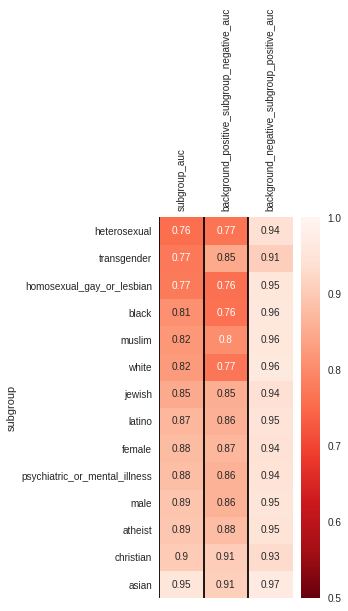

In [14]:
def plot_auc_heatmap(bias_metrics_results, models):
  metrics_list = [SUBGROUP_AUC, BACKGROUND_POSITIVE_SUBGROUP_NEGATIVE_AUC, BACKGROUND_NEGATIVE_SUBGROUP_POSITIVE_AUC]
  df = bias_metrics_results.set_index('subgroup')
  columns = []
  vlines = [i * len(models) for i in range(len(metrics_list))]
  for metric in metrics_list:
    for model in models:
      columns.append(metric)
  num_rows = len(df)
  num_columns = len(columns)
  fig = plt.figure(figsize=(num_columns, 0.5 * num_rows))
  ax = sns.heatmap(df[columns], annot=True, fmt='.2', cbar=True, cmap='Reds_r',
                   vmin=0.5, vmax=1.0)
  ax.xaxis.tick_top()
  plt.xticks(rotation=90)
  ax.vlines(vlines, *ax.get_ylim())
  return ax

plot_auc_heatmap(bias_metrics_df, [MODEL_NAME])

# Exercise #2:
Examine the bias heatmap above - what biases can you spot?  Do the biases appear to be false positives (non-toxic comments incorrectly classified as toxic) or false negatives (toxic comments incorrectly classified as non-toxic)?

## Solution: click to expand

Some groups have lower subgroup AUC scores, for example the groups "heterosexual", "transgender", and "homosexual_gay_or_lesbian".  Because the "Negative Cross AUC" is lower than the "Positive Cross AUC" for this group, it appears that this groups has more false positives, i.e. many non-toxic comments about homosexuals are scoring higher for toxicity than actually toxic comments about other topics.

# Plot histograms showing comment scores

We can graph a histogram of comment scores in each identity.  In the following graphs, the X axis represents the toxicity score given by our new model, and the Y axis represents the comment count.  Blue values are comment whose true label is non-toxic, while red values are those whose true label is toxic.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


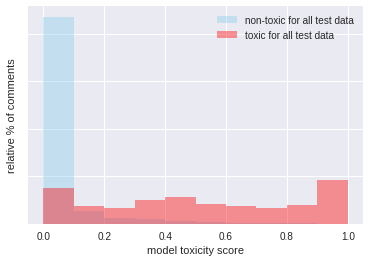

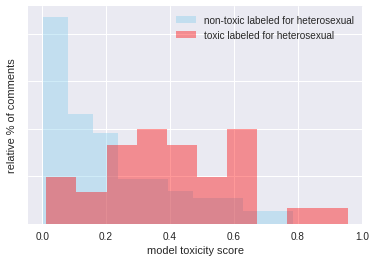

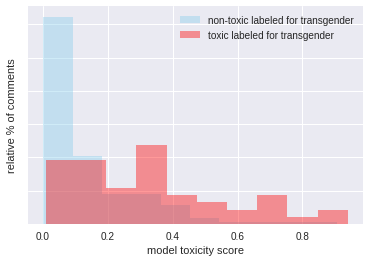

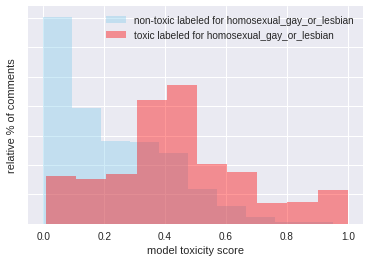

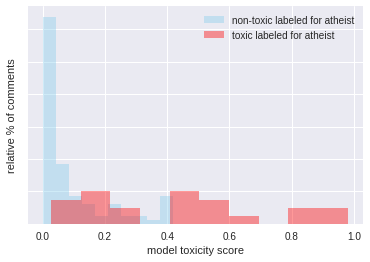

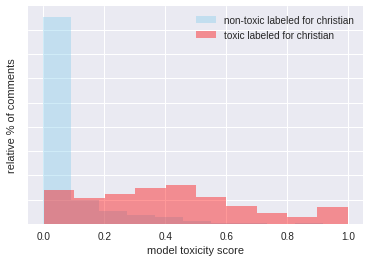

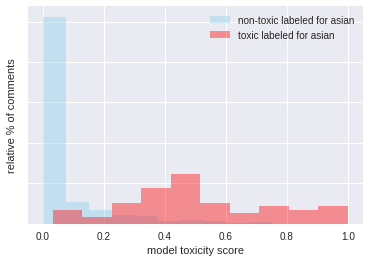

<Figure size 432x288 with 0 Axes>

In [15]:
def plot_histogram(non_toxic_scores, toxic_scores, description):
  NUM_BINS=10
  sns.distplot(non_toxic_scores, norm_hist=True, bins=NUM_BINS, color="skyblue", label='non-toxic ' + description, kde=False)
  ax = sns.distplot(toxic_scores, norm_hist=True, bins=NUM_BINS, color="red", label='toxic ' + description, kde=False)
  ax.set(xlabel='model toxicity score', ylabel='relative % of comments', yticklabels=[])
  plt.legend()
  plt.figure()

# Plot toxicity distributions of different identities to visualize bias.
def plot_histogram_for_identity(df, identity):
  toxic_scores = df.query(identity + ' == True & toxicity == True')[MODEL_NAME]
  non_toxic_scores = df.query(identity + ' == True & toxicity == False')[MODEL_NAME]
  plot_histogram(non_toxic_scores, toxic_scores, 'labeled for ' + identity)

def plot_background_histogram(df):
  toxic_scores = df.query('toxicity == True')[MODEL_NAME]
  non_toxic_scores = df.query('toxicity == False')[MODEL_NAME]
  plot_histogram(non_toxic_scores, toxic_scores, 'for all test data')

# Plot the histogram for the background data, and for a few identities
plot_background_histogram(test_df)
plot_histogram_for_identity(test_df, 'heterosexual')
plot_histogram_for_identity(test_df, 'transgender')
plot_histogram_for_identity(test_df, 'homosexual_gay_or_lesbian')
plot_histogram_for_identity(test_df, 'atheist')
plot_histogram_for_identity(test_df, 'christian')
plot_histogram_for_identity(test_df, 'asian')

# Execise 3

By comparing the toxicity histograms for comments that refer to different groups with each other, and with the background distribution, what additional information can we learn about bias in our model?

In [0]:
# Your code here
#
# HINT: you can display the background distribution by running:
#   plot_background_histogram(test_df)
#
# You can plot the distribution for a given identity by running
#   plot_histogram_for_identity(test_df, identity_name)
#   e.g. plot_histogram_for_identity(test_df, 'male')

## Solution (click to expand)

This is one possible interpretation of the data.  We encourage you to explore other identity categories and come up with your own conclusions.

We can see that for some identities such as Asian, the model scores most non-toxic comments as less than 0.2 and most toxic comments as greater than 0.2.  This indicates that for the Asian identity, our model is able to distinguish between toxic and non-toxic comments.  However, for the black identity, there are many non-toxic comments with scores over 0.5, along with many toxic comments with scores of less than 0.5.  This shows that for the black identity, our model will be less accurate at separating toxic comments from non-toxic comments.  We can see that the model also has difficulty separating toxic from non-toxic data for comments labeled as applying to the "white" identity.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


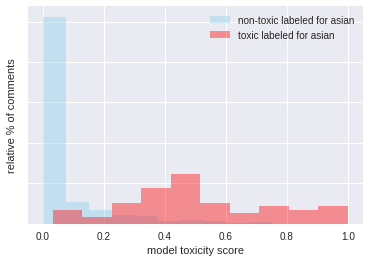

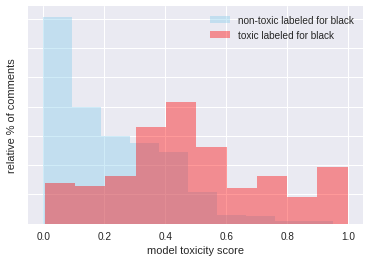

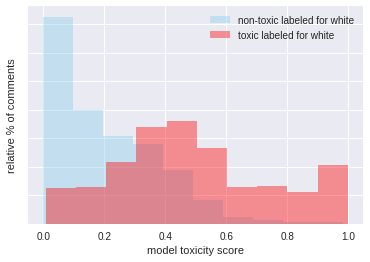

<Figure size 432x288 with 0 Axes>

In [17]:
plot_histogram_for_identity(test_df, 'asian')
plot_histogram_for_identity(test_df, 'black')
plot_histogram_for_identity(test_df, 'white')

# Additional topics to explore
* How does toxicity and bias change if we restrict the dataset to long or short comments?
* What patterns exist for comments containing multiple identities?  Do some identities often appear together?  Are these comments more likely to be toxic?  Is our model more or less biased against these comments?
* What biases exist when classifying the other "toxicity subtypes" (obscene, sexual_explicit, identity_attack, insult, and threat)?
* Are there other ways we might be able to mitigate bias?


# Experimental code, TODO: remove before tutorial

In [0]:
train_df['comment_text_len'] = train_df['comment_text'].apply(lambda x: len(x))

In [0]:
SHORT_CUTOFF = 140
SHORT_TOXICITY_LABEL = '%% toxicity, <= %d characters' % SHORT_CUTOFF
LONG_TOXICITY_LABEL = '%% toxicity, > %d characters' % SHORT_CUTOFF
short_df = train_df.query('comment_text_len <= %d' % SHORT_CUTOFF)
long_df = train_df.query('comment_text_len > %d' % SHORT_CUTOFF)

In [20]:
data = []
for identity in identities_with_over_100_records:
  short_identity = short_df.query('%s == True' % identity)
  percent_toxic_short = 100 * len(short_identity.query('toxicity == True')) / len(short_identity)
  long_identity = long_df.query('%s == True' % identity)
  percent_toxic_long = 100 * len(long_identity.query('toxicity == True')) / len(long_identity)
  print('%s, short %f, long %f' % (identity, percent_toxic_short, percent_toxic_long))
  data.append({'identity': identity, SHORT_TOXICITY_LABEL: percent_toxic_short, LONG_TOXICITY_LABEL: percent_toxic_long})
length_analysis_df = pd.DataFrame(data)

male, short 16.362039, long 15.067144
female, short 16.845389, long 13.283310
transgender, short 35.826772, long 19.513842
heterosexual, short 21.428571, long 22.906404
homosexual_gay_or_lesbian, short 46.016771, long 25.883763
christian, short 12.176871, long 8.881167
jewish, short 24.349442, long 15.217849
muslim, short 30.486078, long 21.407809
atheist, short 10.400000, long 13.769752
black, short 49.511855, long 28.381681
white, short 36.871123, long 26.191717
asian, short 13.284133, long 12.136445
latino, short 23.618090, long 18.444266
psychiatric_or_mental_illness, short 42.404007, long 16.730702


In [0]:
length_analysis_df = length_analysis_df.sort_values('identity')

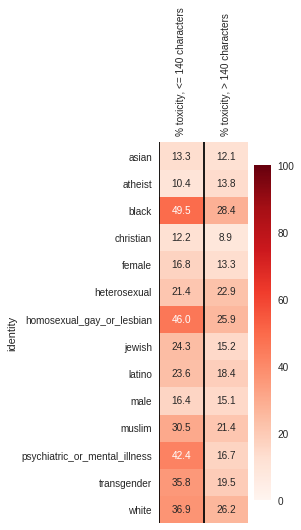

In [22]:
def plot_length_analysis_heatmap(df):
  metrics_list = [SHORT_TOXICITY_LABEL, LONG_TOXICITY_LABEL]
  df = df.set_index('identity')
  columns = []
  vlines = [i for i in range(len(metrics_list))]
  for metric in metrics_list:
    columns.append(metric)
  num_rows = len(df)
  num_columns = len(columns)
  fig = plt.figure(figsize=(num_columns, 0.5 * num_rows))
  ax = sns.heatmap(df[columns], annot=True, fmt='.1f', cbar=True, cmap='Reds',
                   vmin=0, vmax=100)
  ax.xaxis.tick_top()
  plt.xticks(rotation=90)
  ax.vlines(vlines, *ax.get_ylim())
  return ax

plot_length_analysis_heatmap(length_analysis_df)

In [23]:
train_df[['toxicity', 'heterosexual', 'comment_text']].query('heterosexual == True').head(10)

,toxicity,heterosexual,comment_text
5149,True,True,"It's amazing that the women who voted for the pussy-grabber in chief - a heterosexual man who bragged about barging unannounced into teenage girls dressing rooms - and other sexual predations, to lead our country, are stupid enough to think anyone believes they're concerned about the privacy of ..."
5172,False,True,Transgender soldiers can kill just as efficiently as straight soldiers.
6272,False,True,"never ceases to amaze me that abnormal sex is celebrated so much in our society... and if you do not celebrate this abnormal sex, there is something wrong with YOU. Shows just how screwed up priorities in society are.... unless of course, the argument is that non heterosexual people are another..."
6325,True,True,"I can already name the homophobic commenters who will quickly make the leap from this one [alleged] rapist to all gay men, as though they would similarly indict all straight men because some men rape women."
6535,False,True,Many times better than they do straight men in general. They know we aren't going to molest or rape them.
6571,True,True,"Straight* Learn how to spell, and bullshit. No one hates straight people. Only those who are close minded and self centered religious bigots that have nothing better to do then make a big deal out of someone for not being christian or for being LGBT."
6620,True,True,"If wonder if this means feminists will be going back and disowning things like Valerie Solanas' S.C.U.M. Manifiesto. S.C.U.M.? Society for Cutting Up Men. And statements likening all heterosexual sex to rape? Andrea Dworkin, Catharine MacKinnon and their activist sisters all to be disowned now?"
6668,True,True,Heterosexuals do not have sex with juvenile males.\n\nGay pedophiles do.
6742,True,True,"Victimhood is pathetic and your whining is sad, especially as a straight white man. White men still have the world on a silver platter, I should know, I am one too."
19600,True,True,Gay folk don't define themselves by sexual acts any more than heterosexuals to. It is the sodomy-obsessed gay-haters who try to impose such a definition.
